In [2]:
from trip_lib_v3 import *

In [ ]:
def leaning_curve(X,x,c=4):
    
    y = X['ataque']
    X = X[x]
    numerical = X.select_dtypes(exclude=["category",'object']).columns
    categorical = X.select_dtypes(include=["object"]).columns
    t = [('cat', OneHotEncoder(), categorical), ('num', StandardScaler(), numerical)]
    transformer = ColumnTransformer(transformers=t)
    X_train_transformed = transformer.fit_transform(X)
    
#     rf = RandomForestClassifier(n_estimators=100, min_samples_split = 10, min_samples_leaf = 2, max_features = 'auto', bootstrap = False,max_depth=c, random_state=0)
    rf = RandomForestClassifier(n_estimators=95, min_samples_split = 20, min_samples_leaf = 4, max_features = 'auto', bootstrap = True,max_depth=None, random_state=0)
    sizes = np.linspace(0.1, 1.0, 100)
    visualizer = LearningCurve(
    rf, cv=3, scoring='accuracy', train_sizes=sizes, n_jobs=4)

    visualizer.fit(X_train_transformed, y)        # Fit the data to the visualizer
    visualizer.show()  

In [ ]:
def leaning_curve_OP(X,x,c=4):
    
    y = X['ataque']
    X = X[x]
   
    loaded_transform = pickle.load(open('x_transform_OP.sav', 'rb'))
    X_TRANS = loaded_transform.transform(X)
    loaded_model = pickle.load(open('rf_op_model_OP.sav', 'rb'))
#     numerical = X.select_dtypes(exclude=["category",'object']).columns
#     categorical = X.select_dtypes(include=["object"]).columns
#     t = [('cat', OneHotEncoder(), categorical), ('num', StandardScaler(), numerical)]
#     transformer = ColumnTransformer(transformers=t)
#     X_train_transformed = transformer.fit_transform(X)
    
#     rf = RandomForestClassifier(n_estimators=100, min_samples_split = 10, min_samples_leaf = 2, max_features = 'auto', bootstrap = False,max_depth=c, random_state=0)
#     rf = RandomForestClassifier(n_estimators=95, min_samples_split = 20, min_samples_leaf = 4, max_features = 'auto', bootstrap = True,max_depth=None, random_state=0)
    sizes = np.linspace(0.1, 1.0, 100)
    visualizer = LearningCurve(loaded_model , cv=3, scoring='accuracy', train_sizes=sizes, n_jobs=4)

    visualizer.fit(X_TRANS, y)        # Fit the data to the visualizer
    visualizer.show() 

### Predicción de si el tráfico de red pertenece a un ataque cibernético

Se han analizado diferentes tipos de ataques cibernéticos junto con tráfico normal y se han etiquetado estos datos para apicar un modelo de Machine Learning que aprenda a detectar tráfico malicioso.

Las características más destacables que se han detectado son la frecuencia del envío de paquetes y el tamaño que tienen, aunque existen otras características propias de algunos ataques como es el escaneo de puertos o las repetidas llamadas a puertos de control en remoto, por ejemplo. Por estos motivos los datos en crudo se han tratado para calcular y enfatizar estas catacterísticas que puedan hacer que el algoritmo aprenda mejor.

In [4]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import mean_squared_error

In [5]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score

In [6]:
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [7]:
from yellowbrick.model_selection import LearningCurve

C:\Users\34653\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [8]:
import matplotlib.pyplot as plt

### Listas de datos: ataques cibernéticos y tráfico no malicioso

In [3]:
trafico_normal = ['traficoperiodicos.csv','traficoweb.csv','trafico_mail2.csv','traficonormal2.csv','navegacion_normal.csv',
'prueba_trafico_normal_metasplotaible2.csv',
'trafico normal kali linux_meta y vm.csv',
'trafico normal y envio mail.csv',
'trafico_normal_conpin.csv',
'TRAFICO_NORMAL_DE_RED.csv',
'whireshark_navegacion_normal.csv']
trafico_ataques = ['Escaneo_Niktoataque.csv','Escaneo_Openvasataque.csv','Ataque Web Owasp Mutillidae  puerto 80.csv',
'meterpreter y ejecucion de comandos y shell linuxsuggester.csv','nmap owasp.csv',
'nmap_de_kali_a_meta.csv',
'nmap_de_kali_a_meta2.csv',
'nmap_de_meta_a_kali.csv',
'nmap_sV_metaisploitablev2.csv',
'Servidor_web_linux_con_contrasena_crackeada_TRAFICO_DE_RED.csv',
'Servidor_web_linux_sin_contrasena_TRAFICO_DE_RED.csv',
'Windows_con_contrasena_TRAFICO_DE _RED.csv',
'Windows_sin_contrasena_TRAFICO_DE_RED.csv']

In [4]:
import os
os.path.abspath(os.getcwd())

'C:\\Users\\34653\\Documents\\DataScience2_ap2020\\DataSciencieApril_casaWork\\Tripulaciones'

Inicialmente el dataset contiene las siguientes columnas:
* Time: tiempo, lo marca la herramienta que captura el tráfico y se mide en segundos. La diferencia en tiempos entre los paquetes indica la frecuencia a la que se producen los envíos.	
* Source: es la IP origen.
* Destination: es la IP destino.
* Protocol: protocolo de transmisión de información.
* Length: numero de caracteres del paquete.
* Info: contiene información de los puertos origen y destino y del tipo de petición que se hace, entre otros.

In [5]:
df = open_file(trafico_ataques[0])
df.head()

,No.,Time,Source,Destination,Protocol,Length,Info,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,1,0.000000000,10.0.2.4,13.33.235.94,TCP,54,45078 > 443 [ACK] Seq=1 Ack=1 Win=62780 Len=0,NaN,NaN,NaN
1,2,0.000489060,13.33.235.94,10.0.2.4,TCP,60,[TCP ACKed unseen segment] 443 > 45078 [ACK]...,NaN,NaN,NaN
2,3,0.245751753,10.0.2.4,212.145.41.58,TLSv1.2,78,Application Data,NaN,NaN,NaN
3,4,0.245814553,10.0.2.4,212.145.41.58,TCP,54,"40314 > 443 [FIN, ACK] Seq=25 Ack=1 Win=6278...",NaN,NaN,NaN
4,5,0.246512523,212.145.41.58,10.0.2.4,TCP,60,443 > 40314 [ACK] Seq=1 Ack=26 Win=32743 Len=0,NaN,NaN,NaN


Se realizaron distintos cálculos en el dataset como el número de paquetes por segundo y las diferentes variables estadísticas de esta columna (máximo, mínimo, media y desviación típica), así como las mismas variables estadísticas para el tamaño de paquete.

Los datos han sido tratados de la siguiente manera:

El cálculo del número de paquetes por segundo enviados se hizo de manera que en cada instante de tiempo en el que la herramienta nos proporciona datos, tenemos el cálculo de los paquetes/s del último segundo. De la columna info se ha extraído el dato de puerto destino y se ha puesto en una columna aparte. También se ha etiquetado si existe o no escaner de puertos (desde una misma IP realizar peticiones a muchos puertos distintos puede ser una estrategia previa a un ataque) y también se ha etiquetado la presencia de puertos 21 y 22 por ser puertos que solicitan control de máquinas en local y en remoto, respectivamente.

Los datos han sido debidamente transformados a código binario, aplicando distintas transformaciones en función de la naturaleza del mismo (numérico o categórico). Para el modelo de ML se ha empleado un RanomForestClassifier. El modelo hace una predicción de si el tráfico es o no es un ataque en base a un etiquetado previo (Supervised Learning). Los hiperparámetros del modelo han sido optimizados con un RandomizedSearchCV. El modelo se ha validado con un cross_validation y con LearningCurve.


In [11]:
loaded_c = pickle.load(open('data_complete.sav', 'rb'))
com = pd.DataFrame(loaded_c)

In [9]:
com.head()

,escaner,len_mean,len_std,len_min,len_max,puerto_destino,Protocol,Source,Destination,n_paq_mean,n_paq_std,n_paq_min,n_paq_max,n_paquetes,Length,puerto_caliente,ataque,source,destination
797005,1,1548.404421,3858.851526,42.0,46774.0,0,TLSv1.3,172.217.17.1,10.0.2.10,282.779620,319.940321,1.0,1951.0,236,16114,0,0,172.217.17.1,10.0.2.10
118120,1,408.100115,920.331136,42.0,34818.0,80,TCP,10.0.2.4,10.0.2.7,60186.216160,46875.394240,1.0,145467.0,45522,66,0,1,10.0.2.4,10.0.2.7
610044,1,288.014661,434.654449,42.0,1514.0,49450,TCP,10.0.2.6,10.0.2.10,2534.847727,1756.938579,1.0,6616.0,1270,74,0,1,10.0.2.6,10.0.2.10
182141,1,408.100115,920.331136,42.0,34818.0,0,HTTP,10.0.2.4,10.0.2.7,60186.216160,46875.394240,1.0,145467.0,109543,417,0,1,10.0.2.4,10.0.2.7
513004,1,288.014661,434.654449,42.0,1514.0,443,TCP,10.0.2.10,10.0.2.6,2534.847727,1756.938579,1.0,6616.0,1491,66,0,1,10.0.2.10,10.0.2.6


### Prediccion es la función que hace lamada al modelo y hace la predicción de si el tráfico es o no flujo malicioso

<class 'pandas.core.frame.DataFrame'>
Index(['No.', 'Time', 'Source', 'Destination', 'Protocol', 'Length', 'Info',
       'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'len_mean', 'len_std',
       'len_min', 'len_max', 'tiempo_dec(s)', 't_uni', 'n_paquetes',
       'n_paq_mean', 'n_paq_std', 'n_paq_min', 'n_paq_max', 'puerto_caliente',
       'puerto_destino', 'escaner'],
      dtype='object')


C:\Users\34653\Anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:440: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


ATAQUE
Escaneo_Niktoataque.csv  Maximo número de paquetes: 773


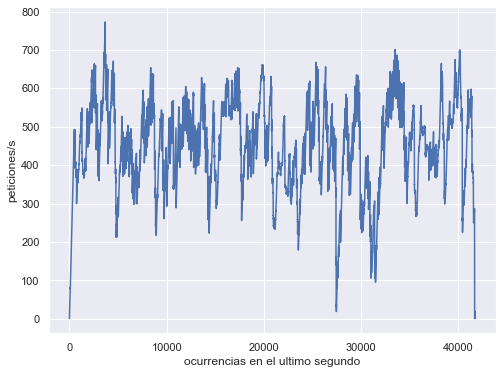

<class 'pandas.core.frame.DataFrame'>


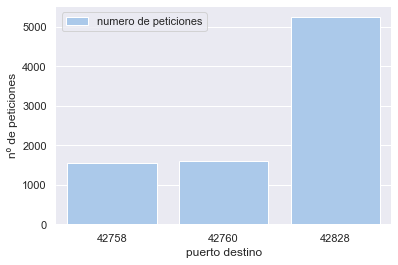

(<Figure size 576x432 with 1 Axes>, None)

In [10]:
prediccion(trafico_ataques[0])

In [1]:
from trip_lib_v3 import *

In [8]:
loaded_c = pickle.load(open('data_complete.sav', 'rb'))
com = pd.DataFrame(loaded_c)

In [3]:

com.head()

,escaner,len_mean,len_std,len_min,len_max,puerto_destino,Protocol,Source,Destination,n_paq_mean,n_paq_std,n_paq_min,n_paq_max,n_paquetes,Length,puerto_caliente,ataque,source,destination
797005,1,1548.404421,3858.851526,42.0,46774.0,0,TLSv1.3,172.217.17.1,10.0.2.10,282.779620,319.940321,1.0,1951.0,236,16114,0,0,172.217.17.1,10.0.2.10
118120,1,408.100115,920.331136,42.0,34818.0,80,TCP,10.0.2.4,10.0.2.7,60186.216160,46875.394240,1.0,145467.0,45522,66,0,1,10.0.2.4,10.0.2.7
610044,1,288.014661,434.654449,42.0,1514.0,49450,TCP,10.0.2.6,10.0.2.10,2534.847727,1756.938579,1.0,6616.0,1270,74,0,1,10.0.2.6,10.0.2.10
182141,1,408.100115,920.331136,42.0,34818.0,0,HTTP,10.0.2.4,10.0.2.7,60186.216160,46875.394240,1.0,145467.0,109543,417,0,1,10.0.2.4,10.0.2.7
513004,1,288.014661,434.654449,42.0,1514.0,443,TCP,10.0.2.10,10.0.2.6,2534.847727,1756.938579,1.0,6616.0,1491,66,0,1,10.0.2.10,10.0.2.6


In [23]:
X=com
x = ['puerto_destino','escaner','n_paquetes','puerto_caliente','Length']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X[x], X['ataque'], test_size=0.3, random_state=42)

### Optimizacion de los hiperparámetros con RandomizedSearchCV SIN variables estadisticas acc = 0.9 ###

In [9]:
# x = ['len_mean','len_std', 'len_min', 'len_max','puerto_destino','n_paq_mean','n_paq_std','n_paq_min','n_paq_max','n_paquetes','Length','puerto_caliente']
x = ['puerto_destino','escaner','n_paquetes','puerto_caliente','Length']
X=com
X_train, X_test, y_train, y_test = train_test_split(X[x], X['ataque'], test_size=0.3, random_state=42)

numerical = X_train.select_dtypes(exclude=["category",'object']).columns
categorical = X_train.select_dtypes(include=["object"]).columns
t = [('cat', OneHotEncoder(), categorical), ('num', StandardScaler(), numerical)]
transformer = ColumnTransformer(transformers=t)
X_train_transformed = transformer.fit_transform(X_train)
#     print(X_test)
X_test_transformed = transformer.transform(X_test)

In [17]:
rf = RandomForestClassifier()
#     rf.fit(X_train_transformed, y_train)
#     fitted_labels = rf.predict(X_test_transformed)
#     score = accuracy_score( fitted_labels,y_test)
#     print('max_depth = ',i,' score:', score)
#     plt.scatter(fitted_labels, y_test)
# Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 95, stop = 150, num = 5)]
n_estimators =[90,95,100,110]
# Number of features to consider at every split
max_features = ['auto','sqrt','log2', None]
# Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(2,6, num = 3)]
max_depth =[3,4,5,6,7]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5,10,15,20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=100, random_state=42, cv=3, verbose=2, n_jobs=3)


In [18]:
rf_search.fit(X_train_transformed, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed: 26.6min
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed: 92.0min
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed: 154.3min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=3,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [3, 4, 5, 6, 7, None],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_leaf': [2, 4],
                                        'min_samples_split': [5, 10, 15, 20],
                                        'n_estimators': [90, 95, 100, 110]},
                   random_state=42, verbose=2)

In [19]:
rf_search.best_params_
best_rf = rf_search.best_estimator_
y_pred = rf_search.predict(X_test_transformed)

In [20]:
rf_search.best_params_

{'n_estimators': 95,
 'min_samples_split': 20,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

In [21]:
best_rf

RandomForestClassifier(min_samples_leaf=4, min_samples_split=20,
                       n_estimators=95)

In [22]:
# y_pred_train = rf_search.predict(X_train_transformed)
# accuracy_train = accuracy_score(y_test,y_pred_train)

precision = precision_score(y_test,y_pred,average='micro')
recall = recall_score(y_test,y_pred,average='micro')
accuracy = accuracy_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred,average='macro')
print("Accuracy of the model is :" ,accuracy)
print("Recall of the model is :" ,recall)
print("Precision of the model is :" ,precision)
print("F1 score of the model is :" ,f1)

Accuracy of the model is : 0.9024119892915713
Recall of the model is : 0.9024119892915713
Precision of the model is : 0.9024119892915713
F1 score of the model is : 0.8629308288592534


C:\Users\34653\Anaconda3\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


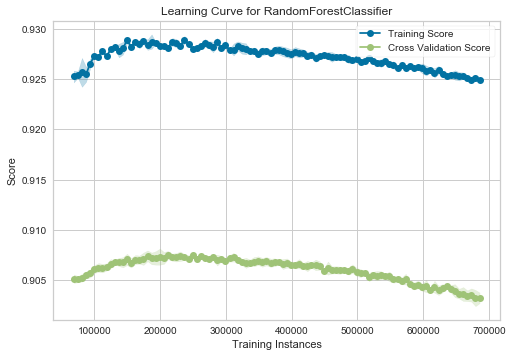

In [38]:
leaning_curve(com,x = ['puerto_destino','escaner','n_paquetes','puerto_caliente','Length'])

In [16]:
def modelo_rf_cross_val(X,c = 5):
#     print(X.columns)
#     print(X['ataque'])
#     X_train, X_test, y_train, y_test = train_test_split(X[['Length']], X['ataque'], test_size=0.3, random_state=42)

    y = X['ataque']
    X = X[['puerto_destino','escaner','n_paquetes','puerto_caliente','Length']]
    
    numerical = X.select_dtypes(exclude=["category",'object']).columns
    categorical = X.select_dtypes(include=["object"]).columns
    t = [('cat', OneHotEncoder(), categorical), ('num', StandardScaler(), numerical)]
    transformer = ColumnTransformer(transformers=t)
    X_trans = transformer.fit_transform(X)
    scores_lista = []
    
    rf = RandomForestClassifier(n_estimators=95, min_samples_split = 20, min_samples_leaf = 4, max_features = 'auto', bootstrap = True,max_depth=None, random_state=0)
#         rf.fit(X_trans, y_train)
#         fitted_labels = rf.predict(X_test_transformed)
    scores = cross_val_score(rf,X_trans, y, cv=c)
    return scores

In [17]:
 modelo_rf_cross_val(com,c = 5)

array([0.90071222, 0.89987554, 0.8995012 , 0.90101802, 0.89982693])

In [33]:
loaded_model = pickle.load(open('rf_op_model_OP.sav', 'rb'))
loaded_transform = pickle.load(open('x_transform_OP.sav', 'rb'))
x_test_transdormed = loaded_transform.transform(X_test[['puerto_destino','escaner','n_paquetes','puerto_caliente','Length']])

y_pred = loaded_model.predict(x_test_transdormed )

### PRUEBA CON MAS HIPERPARAMETROS ###

In [42]:
rf2 = RandomForestClassifier()
#     rf.fit(X_train_transformed, y_train)
#     fitted_labels = rf.predict(X_test_transformed)
#     score = accuracy_score( fitted_labels,y_test)
#     print('max_depth = ',i,' score:', score)
#     plt.scatter(fitted_labels, y_test)
# Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 95, stop = 150, num = 5)]
n_estimators =[90,95,100,110]
# Number of features to consider at every split
max_features = ['auto','sqrt','log2', None]
# Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(2,6, num = 3)]
max_depth =[1,8,14,20,50,100]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [20,30,60,100,1000]
# Minimum number of samples required at each leaf node
min_samples_leaf = [4,8,10,100,1000]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_search2 = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=100, random_state=42, cv=3, verbose=2, n_jobs=3)

In [43]:
rf_search2.fit(X_train_transformed, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed: 12.1min
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed: 54.2min
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed: 100.8min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=3,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [1, 8, 14, 20, 50, 100,
                                                      None],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_leaf': [4, 8, 10, 100,
                                                             1000],
                                        'min_samples_split': [20, 30, 60, 100,
                                                              1000],
                                        'n_estimators': [90, 95, 100, 110]},
                   random_state=42, verbose=2)

In [44]:
rf_search2.best_params_
best_rf = rf_search2.best_estimator_
y_pred = rf_search2.predict(X_test_transformed)

In [45]:
rf_search2.best_params_

{'n_estimators': 100,
 'min_samples_split': 60,
 'min_samples_leaf': 4,
 'max_features': 'log2',
 'max_depth': 20,
 'bootstrap': True}

In [46]:
precision = precision_score(y_test,y_pred,average='micro')
recall = recall_score(y_test,y_pred,average='micro')
accuracy = accuracy_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred,average='macro')
print("Accuracy of the model is :" ,accuracy)
print("Recall of the model is :" ,recall)
print("Precision of the model is :" ,precision)
print("F1 score of the model is :" ,f1)

Accuracy of the model is : 0.9084338598958975
Recall of the model is : 0.9084338598958975
Precision of the model is : 0.9084338598958975
F1 score of the model is : 0.8705468431753431


### Entrenamos y guardamos el modelo: parámetros optimizados ###

In [26]:
def modelo_rf_op(X):
#     print(X.columns)
#     x = GLOBAL_TRAIN_COLUMNS
    GLOBAL_TRAIN_COLUMNS =  ['puerto_destino','escaner','n_paquetes','puerto_caliente','Length']
    X_train, X_test, y_train, y_test = train_test_split(X[x], X['ataque'], test_size=0.3, random_state=42)
    
    numerical = X_train.select_dtypes(exclude=["category",'object']).columns
    categorical = X_train.select_dtypes(include=["object"]).columns
    t = [('cat', OneHotEncoder(), categorical), ('num', StandardScaler(), numerical)]
    transformer = ColumnTransformer(transformers=t)
    X_train_transformed = transformer.fit_transform(X_train)
    
    filename_trans = 'x_transform_OP.sav'
    
    pickle.dump(transformer, open(filename_trans, 'wb'))
#     print(X_test)
    X_test_transformed = transformer.transform(X_test)
    
    rf = RandomForestClassifier(n_estimators=95, min_samples_split = 20, min_samples_leaf = 4, max_features = 'auto', bootstrap = True,max_depth=None, random_state=0)
    rf.fit(X_train_transformed, y_train)
    filename = 'rf_op_model_OP.sav'
    pickle.dump(rf, open(filename, 'wb'))
    y_pred = rf.predict(X_test_transformed)
    precision = precision_score(y_test,y_pred,average='micro')
    recall = recall_score(y_test,y_pred,average='micro')
    accuracy = accuracy_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred,average='macro')
    print("Accuracy of the model is :" ,accuracy)
    print("Recall of the model is :" ,recall)
    print("Precision of the model is :" ,precision)
    print("F1 score of the model is :" ,f1)
#     print('max_depth = ',4,' score:', score)

In [27]:
modelo_rf_op(com)

Accuracy of the model is : 0.9020587148589171
Recall of the model is : 0.9020587148589171
Precision of the model is : 0.9020587148589171
F1 score of the model is : 0.8630174273088419


### Otras pruebas sobre los datos:

### Probando los parametros optimos obtenido variando las variables (añadiendo n_paq_std) acc = 0.99 ##

In [39]:
rf2 = RandomForestClassifier(n_estimators=95, min_samples_split = 10, min_samples_leaf = 4, max_features = 'auto', bootstrap = True,max_depth=None, random_state=0)

In [52]:
# x = ['puerto_destino','escaner','n_paquetes','puerto_caliente','Length']
# x = ['len_mean','len_std', 'len_min', 'len_max','puerto_destino','n_paq_mean','n_paq_std','n_paq_min','n_paq_max','n_paquetes','Length','puerto_caliente']
# x = ['len_mean','len_std', 'len_min', 'len_max','puerto_destino','n_paquetes','Length','puerto_caliente']
# x = ['puerto_destino','n_paq_mean','n_paq_std','n_paq_min','n_paq_max','n_paquetes','Length','puerto_caliente']
# x = ['puerto_destino','n_paq_mean','n_paq_std','n_paq_min','n_paquetes','Length','puerto_caliente']
x = ['puerto_destino','n_paq_std','n_paquetes','Length','puerto_caliente']
X=com
X_train, X_test, y_train, y_test = train_test_split(X[x], X['ataque'], test_size=0.3, random_state=42)
print(X_train.columns)

numerical = X_train.select_dtypes(exclude=["category",'object']).columns
categorical = X_train.select_dtypes(include=["object"]).columns
t = [('cat', OneHotEncoder(), categorical), ('num', StandardScaler(), numerical)]
transformer = ColumnTransformer(transformers=t)
X_train_transformed = transformer.fit_transform(X_train)
#     print(X_test)
X_test_transformed = transformer.transform(X_test)

Index(['puerto_destino', 'n_paq_std', 'n_paquetes', 'Length',
       'puerto_caliente'],
      dtype='object')


In [53]:
rf2.fit(X_train_transformed, y_train)

RandomForestClassifier(min_samples_leaf=4, min_samples_split=10,
                       n_estimators=95, random_state=0)

In [54]:
y_pred = rf2.predict(X_test_transformed)

In [55]:
precision = precision_score(y_test,y_pred,average='micro')
recall = recall_score(y_test,y_pred,average='micro')
accuracy = accuracy_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred,average='macro')
print("Accuracy of the model is :" ,accuracy)
print("Recall of the model is :" ,recall)
print("Precision of the model is :" ,precision)
print("F1 score of the model is :" ,f1)

Accuracy of the model is : 0.9998638759066837
Recall of the model is : 0.9998638759066837
Precision of the model is : 0.9998638759066837
F1 score of the model is : 0.999815679308965


### Correlacion entre todas las variables ###

In [71]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
def corrheat_triangular(df):
    sns.set(style="white")
    
    corr = df.corr()
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=np.bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(10, 8))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap,annot=True, vmin=-1, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

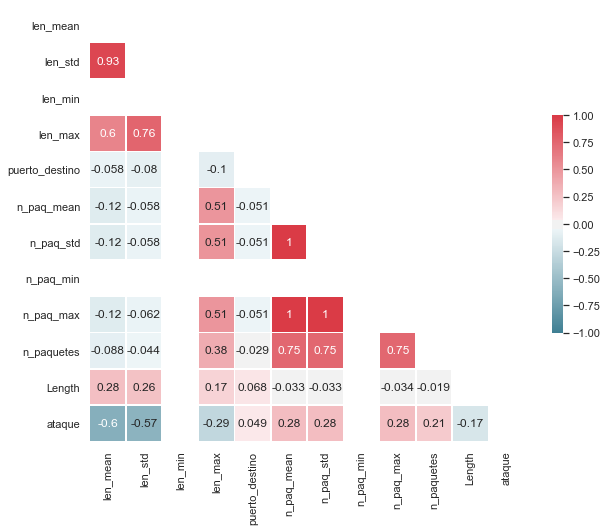

In [72]:
corrheat_triangular(com)

## Eliminamos len_mean y len_std, acc = 1 ###

In [102]:
def modelo_rf_param_optimos(X,x):
    print(X.columns)
#     x = ['puerto_destino','escaner','len_mean','len_std', 'len_min', 'len_max','n_paq_mean','n_paq_std','n_paq_min','n_paq_max','n_paquetes','Length','puerto_caliente']
#     x = ['puerto_destino','escaner','len_mean','len_std', 'len_min', 'len_max','n_paq_mean','n_paq_std','n_paq_min','n_paq_max','n_paquetes','puerto_caliente','Length']
#     x = ['puerto_destino','escaner','n_paquetes','puerto_caliente','Length']
    X_train, X_test, y_train, y_test = train_test_split(X[x], X['ataque'], test_size=0.3, random_state=42)
    
    numerical = X_train.select_dtypes(exclude=["category",'object']).columns
    categorical = X_train.select_dtypes(include=["category",'object']).columns
#     print(numerical,'numerical')
#     print(categorical,'categorical')
    t = [('cat', OneHotEncoder(), categorical), ('num', StandardScaler(), numerical)]
    transformer = ColumnTransformer(transformers=t)
    X_train_transformed = transformer.fit_transform(X_train)
#     print(X_test)
    X_test_transformed = transformer.transform(X_test)
    rf = RandomForestClassifier(n_estimators=95, min_samples_split = 10, min_samples_leaf = 4, max_features = 'auto', bootstrap = True,max_depth=None, random_state=0)
    
    rf.fit(X_train_transformed, y_train)
    y_pred = rf.predict(X_test_transformed)
#     score = accuracy_score( y_pred,y_test)
#     plt.scatter(fitted_labels, y_test)
    
    precision = precision_score(y_test,y_pred,average='micro')
    recall = recall_score(y_test,y_pred,average='micro')
    accuracy = accuracy_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred,average='macro')
    print("Accuracy of the model is :" ,accuracy)
    print("Recall of the model is :" ,recall)
    print("Precision of the model is :" ,precision)
    print("F1 score of the model is :" ,f1)
    
    

In [103]:
x = ['puerto_destino','escaner', 'len_min', 'len_max','n_paq_mean','n_paq_std','n_paq_min','n_paq_max','n_paquetes','Length','puerto_caliente']
modelo_rf_param_optimos(com,x)

Index(['escaner', 'len_mean', 'len_std', 'len_min', 'len_max',
       'puerto_destino', 'Protocol', 'Source', 'Destination', 'n_paq_mean',
       'n_paq_std', 'n_paq_min', 'n_paq_max', 'n_paquetes', 'Length',
       'puerto_caliente', 'ataque', 'source', 'destination'],
      dtype='object')
Accuracy of the model is : 1.0
Recall of the model is : 1.0
Precision of the model is : 1.0
F1 score of the model is : 1.0


In [84]:
from yellowbrick.model_selection import LearningCurve

C:\Users\34653\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [89]:
print(x)

['puerto_destino', 'escaner', 'len_min', 'len_max', 'n_paq_mean', 'n_paq_std', 'n_paq_min', 'n_paq_max', 'n_paquetes', 'Length', 'puerto_caliente']


C:\Users\34653\Anaconda3\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


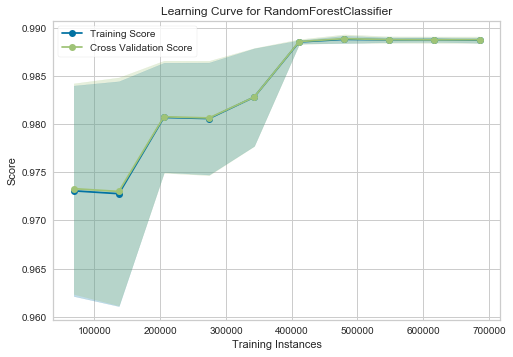

In [90]:
leaning_curve(com,x)

### Cálculo de hiperparámetros optimos para las variables elegidas (quitando len_mean y len_std) ###

In [95]:
X=com
x = ['puerto_destino','escaner', 'len_min', 'len_max','n_paq_mean','n_paq_std','n_paq_min','n_paq_max','n_paquetes','Length','puerto_caliente']
X_train, X_test, y_train, y_test = train_test_split(X[x], X['ataque'], test_size=0.3, random_state=42)

numerical = X_train.select_dtypes(exclude=["category",'object']).columns
categorical = X_train.select_dtypes(include=["object"]).columns
t = [('cat', OneHotEncoder(), categorical), ('num', StandardScaler(), numerical)]
transformer = ColumnTransformer(transformers=t)
X_train_transformed = transformer.fit_transform(X_train)
#     print(X_test)
X_test_transformed = transformer.transform(X_test)

In [104]:
rf = RandomForestClassifier()
#     rf.fit(X_train_transformed, y_train)
#     fitted_labels = rf.predict(X_test_transformed)
#     score = accuracy_score( fitted_labels,y_test)
#     print('max_depth = ',i,' score:', score)
#     plt.scatter(fitted_labels, y_test)
# Number of trees in random forest
# n_estimators=95, min_samples_split = 10, min_samples_leaf = 4, max_features = 'auto', bootstrap = True,max_depth=None
# n_estimators = [int(x) for x in np.linspace(start = 90, stop = 130, num = 5)]
n_estimators =[90,95,100,110]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(2,5, num = 4)]
max_depth = [2,3,4,5,None]
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=100, random_state=42, cv=3, verbose=2, n_jobs=3)

In [ ]:
rf_search.fit(X_train_transformed, y_train)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  5.1min


In [99]:
rf_search.best_params_
best_rf = rf_search.best_estimator_
y_pred = rf_search.predict(X_test_transformed)
rf_search.best_params_
best_rf


RandomForestClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=10)

In [101]:
rf_search.best_params_

{'n_estimators': 100,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 5,
 'bootstrap': True}

In [100]:
precision = precision_score(y_test,y_pred,average='micro')
recall = recall_score(y_test,y_pred,average='micro')
accuracy = accuracy_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred,average='macro')
print("Accuracy of the model is :" ,accuracy)
print("Recall of the model is :" ,recall)
print("Precision of the model is :" ,precision)
print("F1 score of the model is :" ,f1)

Accuracy of the model is : 0.9991832554401021
Recall of the model is : 0.9991832554401021
Precision of the model is : 0.9991832554401021
F1 score of the model is : 0.9988951759138547
